In [1]:
import xarray as xr
import numpy as np
import functions as fun
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
#mods = fun.models()
mods = ['bcc-csm1-1','CanESM2','CCSM4','CNRM-CM5','CSIRO-Mk3-6-0','GFDL-CM3','GISS-E2-R','HadGEM2-ES','inmcm4','IPSL-CM5A-LR','MIROC-ESM','MIROC5','MRI-CGCM3','NorESM1-M']

In [3]:
#Get 1x1 degree grid
with xr.open_dataset('../rawdata/rsl_85_2090.nc') as ds:
    lon = ds['x'].values
    lat = ds['y'].values
    slr_md = ds['slr_md'].values
    
#Get fingerprints
with xr.open_dataset('../rawdata/fp_uniform/AIS.nc') as ds:
    lon05  = ds['x'].values
    lat05  = ds['y'].values
    fp05_a = ds['rsl'].values
with xr.open_dataset('../rawdata/fp_uniform/EAIS.nc') as ds:
    fp05_ea = ds['rsl'].values    
with xr.open_dataset('../rawdata/fp_uniform/WAIS.nc') as ds:
    fp05_wa = ds['rsl'].values    
with xr.open_dataset('../rawdata/fp_uniform/GrIS.nc') as ds:
    fp05_gr = ds['rsl'].values
fp05_gl = np.zeros((19,len(lat05),len(lon05)))
for r in range(1,20):
    with xr.open_dataset(f'../rawdata/fp_uniform/RGI_{r}.nc') as ds:
        fp05_gl[r-1,:,:] = ds['rsl'].values

#Convert to 1x1 degree grid
fp_a  = np.zeros((len(lat),len(lon)))
fp_ea  = np.zeros((len(lat),len(lon)))
fp_wa  = np.zeros((len(lat),len(lon)))
fp_gr = np.zeros((len(lat),len(lon)))
fp_gl = np.zeros((19,len(lat),len(lon)))

for i,ii in enumerate(lat):
    ig = np.argmin((ii-lat05)**2)
    for j,jj in enumerate(lon):
        jg = np.argmin((jj-lon05)**2)
        fp_a[i,j] = fp05_a[ig,jg]
        fp_ea[i,j] = fp05_ea[ig,jg]
        fp_wa[i,j] = fp05_wa[ig,jg]        
        fp_gr[i,j] = fp05_gr[ig,jg]
        fp_gl[:,i,j] = fp05_gl[:,ig,jg]

In [4]:
basin = ['eais','wedd','amun','ross','apen']
imods = ['AISM_VUB','BISI_LBL','CISM_NCA','FETI_VUB','GRIS_LSC','IMAU_VUB','ISSM_JPL','ISSM_UCI','MALI_LAN','PISM_AWI','PISM_DMI','PISM_PIK','PISM_VUW','PS3D_PSU','SICO_UHO','UA_UNN']

R = np.zeros((len(imods),len(basin),200))
for b,bb in enumerate(range(1,6)):
    for i,imod in enumerate(imods):
        with open(f'../rawdata/Larmip2019-master/RFunctions/RF_{imod}_BM08_R{bb}.dat') as f:
            R[i,b,:] = np.array([float(x) for x in f.readlines()])

In [5]:
#Sterodynamic
def estdn(scen,N):
    ens = np.zeros((len(mods),len(lat),len(lon)))
    gens = np.zeros((len(mods),N))

    for m,model in enumerate(mods):
        with xr.open_dataset(f'../data/rsl/{model}_{scen}.nc') as ds:
            ens[m,:,:] = np.nanmean(ds['stdn'][-20:,:,:].values,axis=0)
        with xr.open_dataset(f'../data/steric/{model}_{scen}.nc') as ds:              
            SLR = ds['SLR'].values
            gens[m,:] = np.nanmean(SLR)
            
    return np.repeat(ens[:,np.newaxis,:,:],N,axis=1),gens

In [6]:
#Glaciers
def eglac(scen,N):
    ens = np.zeros((len(mods),len(lat),len(lon)))
    gens = np.zeros((len(mods),N))

    for m,model in enumerate(mods):
        with xr.open_dataset(f'../data/rsl/{model}_{scen}.nc') as ds:
            ens[m,:,:] = np.nanmean(ds['glac'][-20:,:,:].values,axis=0)
        with xr.open_dataset(f'../data/glacier/{model}_{scen}.nc') as ds:
            SLR = ds['SLR'].values
            gens[m,:] = np.nanmean(SLR)
    std = np.nanstd(gens[:,0])
    print(np.nanvar(gens[:,0]))
    gens += np.random.normal(loc=0,scale=std,size=(len(mods),N))
    print(np.nanvar(gens.flatten()))
    #Sample from process uncertainty, independent from model
            
    return np.repeat(ens[:,np.newaxis,:,:],N,axis=1),gens

In [7]:
#Greenland SMB
def egsmb(scen,N):
    ens = np.zeros((len(mods),N,len(lat),len(lon)))
    gens = np.zeros((len(mods),N))

    for m,model in enumerate(mods):

        with xr.open_dataset(f'../rawdata/Gsmb_vars/{model}_{scen}.nc') as ds:
            TA = ds['TA'].values
            SF = ds['SF'].values
            years = ds['time'].values
        MW  = 84.2*TA + 2.4*TA**2. + 1.6*TA**3.
        SMB = SF-MW

        #Skewed uncertainty following AR5
        F = np.exp(np.random.normal(loc=0.0, scale=0.4, size=N))
        for n in range(N):
            SLR = -np.cumsum(F[n]*SMB)*2.8e-4 #in cm
            SLR = fun.detrend(SLR,np.array([]),years) #Reference to ref period
            gens[m,n] = np.nanmean(SLR[-20:])
            ens[m,n,:,:] = np.nanmean(SLR[-20:])*fp_gr
            ens[m,n,:,:][np.isnan(slr_md)] = np.nan

        #print('got gsmb',model)
    return ens,gens

In [8]:
#Antarctic SMB
def easmb(scen,N):
    ens = np.zeros((len(mods),N,len(lat),len(lon)))
    gens = np.zeros((len(mods),N))
    
    for m,model in enumerate(mods):

        with xr.open_dataset(f'../rawdata/Gsmb_vars/{model}_{scen}.nc') as ds:
            TA = ds['TA'].values
            years = ds['time'].values

        #Uncertainty following AR5
        P = np.random.normal(loc=0.051, scale = 0.015,size=N)
        for n in range(N):
            SMB = 1923*P[n]*TA
            SMB[years<1995]=0
            SLR = -np.cumsum(SMB)*2.8e-4 #in cm
            gens[m,n] = np.nanmean(SLR[-20:])
            ens[m,n,:,:] = np.nanmean(SLR[-20:])*fp_a
            ens[m,n,:,:][np.isnan(slr_md)] = np.nan
        #print('got asmb',model)
    return ens,gens

In [9]:
#Antarctic dynamics
def eadyn(scen,N):
    ens = np.zeros((len(mods),N,len(lat),len(lon)))
    gens = np.zeros((len(mods),N))
    
    for m,model in enumerate(mods):  

        with xr.open_dataset(f'../rawdata/Adyn_temp/{model}_{scen}.nc') as ds:
            TH = ds['TH'].values
            years = ds['time'].values

        #Uncertainty following Levermann et al 2020
        bms = np.random.uniform(7,16,N)
        ii  = np.random.randint(len(imods), size=N)

        for n in range(N):   
            for b,bb in enumerate(range(1,6)):
                SLR = np.zeros(len(years))
                for t,tt in enumerate(years):
                    if t==0: continue
                    SLR[t] = bms[n]*100*np.sum(TH[b,:t][::-1]*R[ii[n],b,:t])
                SLR = fun.detrend(SLR,np.array([]),years)
                gens[m,n] += np.nanmean(SLR[-20:])
                if b in [0,1,3]:
                    ens[m,n,:,:] += np.nanmean(SLR[-20:])*fp_ea
                else:
                    ens[m,n,:,:] += np.nanmean(SLR[-20:])*fp_wa
            ens[m,n,:,:][np.isnan(slr_md)] = np.nan
            
        #print('got adyn',model)
    return ens,gens

In [10]:
#Pure process uncertainties
def proc(scen):
    with xr.open_dataset(f'../rawdata/component-ts-slr-{scen[-2:]}.nc') as ds:
        gdyn_h = 100.*np.nanmean(ds['greendyn_h'].values[-20:,:,:],axis=0)
        gdyn_l = 100.*np.nanmean(ds['greendyn_l'].values[-20:,:,:],axis=0)
        lws_h  = 100.*np.nanmean(ds['grw_h'].values[-20:,:,:],axis=0)
        lws_l  = 100.*np.nanmean(ds['grw_l'].values[-20:,:,:],axis=0)
        gia = 100.*np.nanmean(ds['gia_sd'].values[-20:,:,:],axis=0)

    gdyn = (np.abs(gdyn_h-gdyn_l)/(2*1.645))**2.
    lws = (np.abs(lws_h-lws_l)/(2*1.645))**2.
    gia = gia**2.
    gdyn[np.isnan(slr_md)] = np.nan
    lws[np.isnan(slr_md)] = np.nan
    gia[np.isnan(slr_md)] = np.nan
    return gdyn,lws,gia

/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


5.147523245389938
9.937461972474994


/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Degrees of freedom <= 0 for slice.
  if sys.path[0] == '':
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice.
  del sys.path[0]
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Degrees of free

-----Saved rcp45-------
stdn_glac 0.35242839772665374
stdn_gsmb 0.38736104283898065
stdn_asmb -0.23150126953996014
stdn_adyn -0.052116596263480655
glac_gsmb 0.44620443712953667
glac_asmb -0.4425676300115843
glac_adyn -0.0634798259835533
gsmb_asmb -0.5964010719848616
gsmb_adyn -0.24927461753038582
asmb_adyn 0.2951606560295178


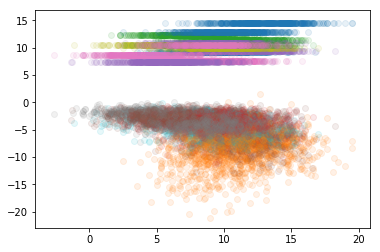

5.650121235425978
11.441741915031802
-----Saved rcp85-------
stdn_glac 0.3609882445888602
stdn_gsmb 0.25149465921027025
stdn_asmb -0.22093330794207064
stdn_adyn -0.01709678973988125
glac_gsmb 0.42893325656715103
glac_asmb -0.41371032214569176
glac_adyn 0.03794038450607199
gsmb_asmb -0.7182776598365704
gsmb_adyn -0.301845851337962
asmb_adyn 0.23007799162258294


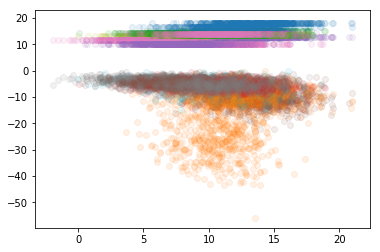

In [11]:
N = 500
for s,scen in enumerate(['rcp45','rcp85']):

    #Variance per component
    eestdn,gestdn = estdn(scen,N)
    eeglac,geglac = eglac(scen,N)
    eegsmb,gegsmb = egsmb(scen,N)
    eeasmb,geasmb = easmb(scen,N)
    eeadyn,geadyn = eadyn(scen,N)
    gdyn,lws,gia = proc(scen)
    
    stdn = np.nanvar(eestdn,axis=(0,1))
    glac = np.nanvar(eeglac,axis=(0,1))*2.
    gsmb = np.nanvar(eegsmb,axis=(0,1))
    asmb = np.nanvar(eeasmb,axis=(0,1))
    adyn = np.nanvar(eeadyn,axis=(0,1))

    #Variance in total RSL
    ersl = eestdn+eeglac+eegsmb+eeasmb+eeadyn
    rsl = np.nanvar(ersl,axis=(0,1))
    #Add independent process variances
    rsl += np.nanvar(eeglac,axis=(0,1))+gdyn+lws+gia
   
    #Save
    stdn2 = xr.DataArray(stdn,dims=('lat','lon'),coords={'lat':lat,'lon':lon})
    glac2 = xr.DataArray(glac,dims=('lat','lon'),coords={'lat':lat,'lon':lon})
    gsmb2 = xr.DataArray(gsmb,dims=('lat','lon'),coords={'lat':lat,'lon':lon})
    asmb2 = xr.DataArray(asmb,dims=('lat','lon'),coords={'lat':lat,'lon':lon})
    adyn2 = xr.DataArray(adyn,dims=('lat','lon'),coords={'lat':lat,'lon':lon})
    gdyn2 = xr.DataArray(gdyn,dims=('lat','lon'),coords={'lat':lat,'lon':lon})
    lws2 = xr.DataArray(lws,dims=('lat','lon'),coords={'lat':lat,'lon':lon})
    gia2 = xr.DataArray(gia,dims=('lat','lon'),coords={'lat':lat,'lon':lon})
    rsl2 = xr.DataArray(rsl,dims=('lat','lon'),coords={'lat':lat,'lon':lon})

    ds = xr.Dataset({'stdn':stdn2,'glac':glac2,'gsmb':gsmb2,'asmb':asmb2,'adyn':adyn2,'gdyn':gdyn2,'lws':lws2,'gia':gia2,'rsl':rsl2})
    ds.to_netcdf(f'../data/totvar_comp_{scen}.nc')

    ds.close()
    print(f'-----Saved {scen}-------')
    
    #Global effective correlation
    for m,model in enumerate(mods):
        plt.scatter(geglac[m,:],gestdn[m,:],alpha=.1)
        plt.scatter(geglac[m,:],geasmb[m,:],alpha=.1)
    print('stdn_glac',st.spearmanr(gestdn.flatten(),geglac.flatten())[0])
    print('stdn_gsmb',st.spearmanr(gestdn.flatten(),gegsmb.flatten())[0])
    print('stdn_asmb',st.spearmanr(gestdn.flatten(),geasmb.flatten())[0])
    print('stdn_adyn',st.spearmanr(gestdn.flatten(),geadyn.flatten())[0])
    print('glac_gsmb',st.spearmanr(geglac.flatten(),gegsmb.flatten())[0])
    print('glac_asmb',st.spearmanr(geglac.flatten(),geasmb.flatten())[0])
    print('glac_adyn',st.spearmanr(geglac.flatten(),geadyn.flatten())[0])
    print('gsmb_asmb',st.spearmanr(gegsmb.flatten(),geasmb.flatten())[0])
    print('gsmb_adyn',st.spearmanr(gegsmb.flatten(),geadyn.flatten())[0])
    print('asmb_adyn',st.spearmanr(geasmb.flatten(),geadyn.flatten())[0])
    plt.show()